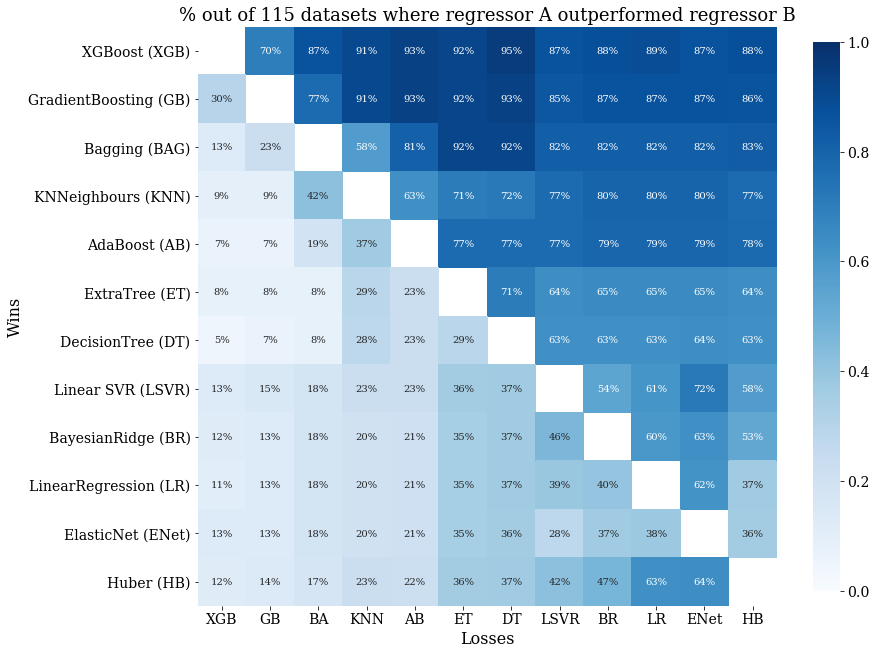

In [28]:
import sys
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import warnings
import seaborn as sb
import operator

import plotly
import plotly.graph_objs as go
from plotly import tools
import plotly.io as pio


warnings.filterwarnings('ignore')

rcParams['font.family'] = "serif"

size_title = 18
size_xlabel = 16
size_ylabel = 16
size_xticks = 14
size_yticks = 14
size_colorbar = 14

folder_name = "scikit_20/tuning/"
clf_names_dir = os.listdir(folder_name)

excluded_clf = ["ExtraTrees", "RandomForest"]

clf_names_dir = [clf for clf in clf_names_dir if clf not in excluded_clf]

clf_names = list()
r2_dict = dict()
clf_sum_r2 = dict()
fit_time_dict = dict()


for clf in clf_names_dir:
    data_path = folder_name + clf
    files = [f for f in os.listdir(data_path)]
    r2_scores = list()
    r2_dict[clf] = list()
    fit_time = list()
    for f_name in files:
        f_path = data_path + "/" + f_name
        df = pd.read_csv(f_path, sep="\t")
        rank_test_score = df[df["rank_test_score"] == 1]
        mean_test_score = rank_test_score["mean_test_score"]
        fit_time_sec = rank_test_score["mean_fit_time"].iloc[0] + rank_test_score["mean_score_time"].iloc[0]
        fit_time.append(fit_time_sec)
        r2_scores.append(mean_test_score.iloc[0])
    r2_dict[clf] = r2_scores
    clf_sum_r2[clf] = np.sum(r2_scores)
    clf_names.append(clf)
    mean_fit_time = np.mean(fit_time)
    fit_time_dict[clf] = mean_fit_time
n_clf = len(clf_names)

sorted_clf = sorted(clf_sum_r2.items(), key=lambda kv: kv[1], reverse=True)
clf_sorted = [a[0] for a in sorted_clf]

model_nice_dict = {
    'XGBoost': 'XGB',
    #'ExtraTrees': 'ETs',
    'GradientBoosting': 'GB',
    #'RandomForest': 'RF',
    'Bagging': 'BA',
    'KNNeighbours': 'KNN',
    'AdaBoost': 'AB',
    'ExtraTree': 'ET',
    'DecisionTree': 'DT',
    'LinearSVR': 'LSVR',
    'BayesianRidge': 'BR',
    'LinearRegression': 'LR',
    'ElasticNet': 'ENet',
    'Huber': 'HB'
}

model_nice_dict_y = {
    'XGBoost': 'XGBoost (XGB)',
    #'ExtraTrees': 'ExtraTrees (ETs)',
    'GradientBoosting': 'GradientBoosting (GB)',
    #'RandomForest': 'RandomForest (RF)',
    'Bagging': 'Bagging (BAG)',
    'KNNeighbours': 'KNNeighbours (KNN)',
    'AdaBoost': 'AdaBoost (AB)',
    'ExtraTree': 'ExtraTree (ET)',
    'DecisionTree': 'DecisionTree (DT)',
    'LinearSVR': 'Linear SVR (LSVR)',
    'BayesianRidge': 'BayesianRidge (BR)',
    'LinearRegression': 'LinearRegression (LR)',
    'ElasticNet': 'ElasticNet (ENet)',
    'Huber': 'Huber (HB)'
}

x_labels = list(model_nice_dict.values())
y_labels = list(model_nice_dict_y.values())

# plot heatmap
performance_datasets = np.zeros(shape=(n_clf, n_clf), dtype=float)

for x, clf_x in enumerate(clf_sorted):
    for y, clf_y in enumerate(clf_sorted):
        x_perf = r2_dict[clf_x]
        y_perf = r2_dict[clf_y]
        n_datasets = len(r2_dict[clf_x])
        x_g_y = len([1 for (a,b) in zip(x_perf, y_perf) if a > b]) / float(n_datasets)
        y_g_x = len([1 for (a,b) in zip(x_perf, y_perf) if b >= a]) / float(n_datasets)
        performance_datasets[x][y] = x_g_y
        performance_datasets[y][x] = y_g_x

mask_matrix = []
for x in range(n_clf):
    for y in range(n_clf):
        mask_matrix.append(x == y)
mask_matrix = np.array(mask_matrix).reshape(n_clf, n_clf)

performance_datasets = np.round((performance_datasets), 2)

plt.figure(figsize=(13, 13))
ax = sb.heatmap(performance_datasets,
           fmt='0.0%',
           mask=mask_matrix,
           cmap='Blues',
           square=True, annot=True, vmin=0.0, vmax=1.0,
           xticklabels=x_labels, yticklabels=y_labels, 
           cbar=True, 
           cbar_kws={"shrink": 0.6}
          )

cbar = ax.collections[0].colorbar
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=size_colorbar)

plt.xticks(fontsize=size_xticks)
plt.yticks(fontsize=size_yticks)
plt.xlabel('Losses', fontsize=size_xlabel)
plt.ylabel('Wins', fontsize=size_ylabel)
plt.title('% out of '+ str(n_datasets) +' datasets where regressor A outperformed regressor B', fontsize=size_title)
h = plt.gcf()
plt.tight_layout()
plt.show()

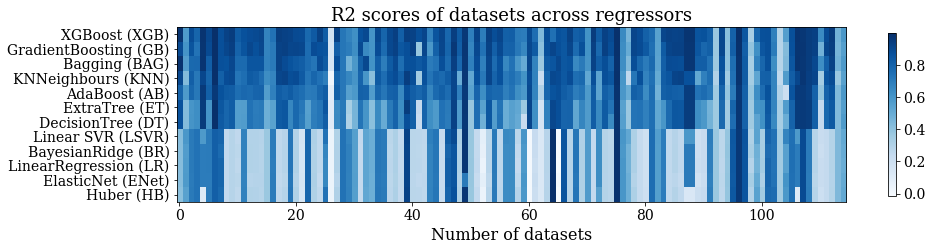

In [29]:
# plot r2-clf matrix

r2_clf_matrix = np.zeros(shape=(n_clf, n_datasets), dtype=float)
plt.figure(figsize=(15, 15))

for x, clf in enumerate(clf_sorted):
    r2_clf_matrix[x] = r2_dict[clf]

plt.title('R2 scores of datasets across regressors', size=size_title)
plt.xlabel('Number of datasets', size=size_xlabel)
plt.yticks(range(n_clf), y_labels, size=size_yticks)
plt.xticks(size=size_xticks)
plt.imshow(r2_clf_matrix, cmap='Blues', aspect=2.5)
cbar = plt.colorbar(shrink=0.2)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=size_yticks)
plt.show()

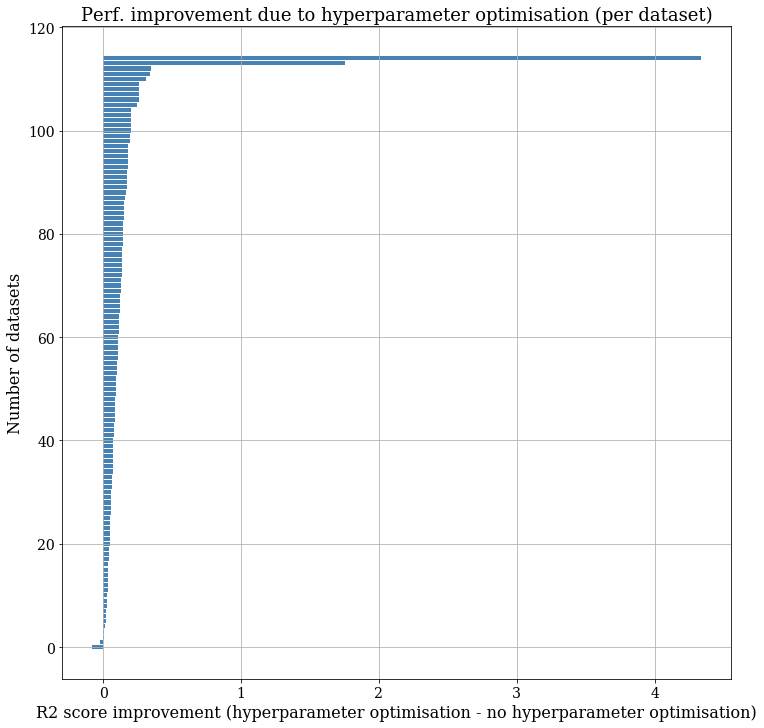

In [30]:
folder_name_tuning = "scikit_20/tuning/"
folder_name_no_tuning = "scikit_20/no_tuning/"

clf_names_dir_tuning = os.listdir(folder_name_tuning)
clf_names_dir_tuning = [clf for clf in clf_names_dir_tuning if clf not in excluded_clf]

clf_names_dir_no_tuning = os.listdir(folder_name_no_tuning)
clf_names_dir_no_tuning = [clf for clf in clf_names_dir_no_tuning if clf not in excluded_clf]

clf_names_tuning = list()
clf_mean_r2_tuning = list()
r2_dict_tuning = dict()
fit_time_dict_tuning = dict()

for clf in clf_names_dir_tuning:
    data_path = folder_name_tuning + clf
    files = [f for f in os.listdir(data_path)]
    r2_scores = list()
    opt_fnames = list()
    for f_name in files:
        opt_fnames.append(f_name)
        f_path = data_path + "/" + f_name
        df = pd.read_csv(f_path, sep="\t")
        rank_test_score = df[df["rank_test_score"] == 1]
        mean_test_score = rank_test_score["mean_test_score"]
        r2_scores.append(mean_test_score.iloc[0])
    clf_names_tuning.append(clf)
    r2_dict_tuning[clf] = r2_scores

clf_names_no_tuning = list()
clf_mean_r2_no_tuning = list()
r2_dict_no_tuning = dict()
fit_time_dict_no_tuning = dict()

for clf in clf_names_dir_no_tuning:
    data_path = folder_name_no_tuning + clf
    files = [f for f in os.listdir(data_path)]
    r2_scores = list()
    no_opt_fnames = list()
    for f_name in files:
        no_opt_fnames.append(f_name)
        f_path = data_path + "/" + f_name
        df = pd.read_csv(f_path, sep="\t")
        rank_test_score = df[df["rank_test_score"] == 1]
        mean_test_score = rank_test_score["mean_test_score"]
        r2_scores.append(mean_test_score.iloc[0])
    clf_names_no_tuning.append(clf)
    r2_dict_no_tuning[clf] = r2_scores

n_datasets = len(no_opt_fnames)
n_clf = len(clf_names_no_tuning)
clf_datasets_perf = np.zeros(shape=(n_clf, n_datasets), dtype=float)
diff_dict = dict()
negative_diff = dict()
for x, clf in enumerate(clf_names_no_tuning):
    tuning_perf = r2_dict_tuning[clf]
    no_tuning_perf = r2_dict_no_tuning[clf]
    diff = [(a-b) for a,b in zip(tuning_perf, no_tuning_perf)]
    diff_dict[clf] = diff
    clf_datasets_perf[x] = diff
    
clf_df = pd.DataFrame(clf_datasets_perf)
clf_df.to_csv("clf_datasets_perf.csv", sep=",")
        
mean_perf_datasets = np.mean(clf_datasets_perf, axis=0)

c_fname = [(a,b) for (a,b) in zip(opt_fnames, mean_perf_datasets) if b < 0.0]

plt.figure(figsize=(12, 12))
y_pos = np.arange(n_datasets)
plt.barh(y_pos, sorted(mean_perf_datasets), color='steelblue')
plt.xlabel('R2 score improvement (hyperparameter optimisation - no hyperparameter optimisation)', size=size_xlabel)
plt.ylabel('Number of datasets', size=size_ylabel)
plt.yticks(size=size_yticks)
plt.xticks(size=size_xticks)
plt.title('Perf. improvement due to hyperparameter optimisation (per dataset)', size=size_title)
plt.grid(True)
plt.show()


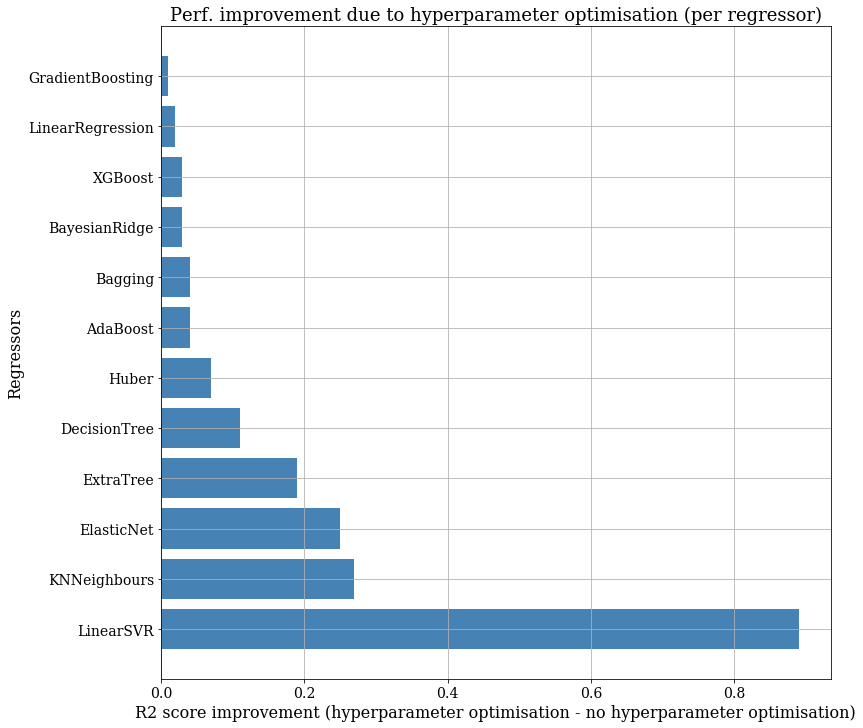

In [27]:
# plot hyperparameter tuninig improvement per regressor
hyper_improvement = dict()

for clf in clf_names_no_tuning:
    mean_no_tuning = np.mean(r2_dict_no_tuning[clf])
    mean_tuning = np.mean(r2_dict_tuning[clf])
    diff = (mean_tuning - mean_no_tuning)
    hyper_improvement[clf] = np.round(diff, 2)

hyper_improvement = sorted(hyper_improvement.items(), key=lambda kv: kv[1], reverse=True)

y_labels = list()
improvement = list()
for k,v in hyper_improvement:
    y_labels.append(k)
    improvement.append(v)   

plt.figure(figsize=(12, 12))
plt.yticks(range(len(y_labels)), y_labels, size=size_yticks)
y_pos = np.arange(len(y_labels))
plt.barh(y_pos, improvement, color='steelblue')
plt.xlabel('R2 score improvement (hyperparameter optimisation - no hyperparameter optimisation)', size=size_xlabel)
plt.ylabel('Regressors', size=size_ylabel)
plt.title('Perf. improvement due to hyperparameter optimisation (per regressor)', size=size_title)
plt.xticks(size=size_xticks)
plt.yticks(size=size_yticks)
plt.grid(True)
plt.show()
    
    

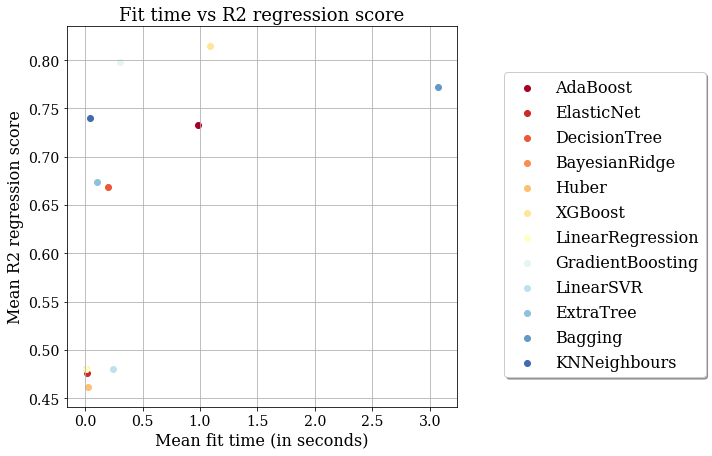

In [34]:
NUM_COLORS = len(clf_names)
cm = plt.get_cmap('RdYlBu')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
fontsz = 18

names_clf = list()
fit_time = list()
r2_scores = list()
ctr = 0

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)

for item in r2_dict.items():
    ax.scatter(fit_time_dict[item[0]], np.mean(item[1]), c=colors[ctr], label=item[0])
    ctr += 1

plt.grid(True)
plt.title("Fit time vs R2 regression score", size=size_title)
plt.xlabel("Mean fit time (in seconds)", size=size_xlabel)
plt.ylabel("Mean R2 regression score", size=size_ylabel)
plt.xticks(size=size_xticks)
plt.yticks(size=size_yticks)
ax.legend(bbox_to_anchor=(1.1, 0.90), shadow=True, ncol=1, prop={'size': size_ylabel})
plt.show()

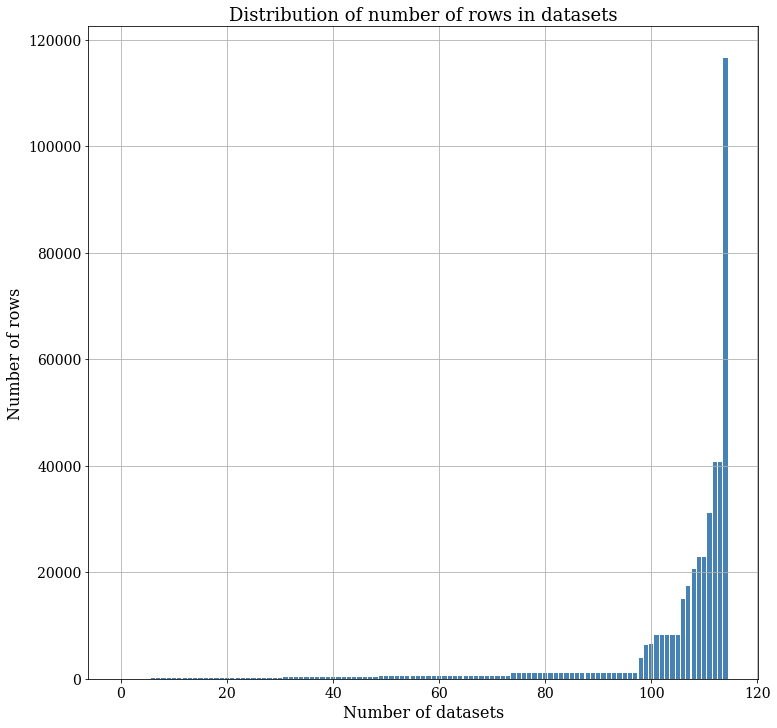

In [35]:
# plot dataset sizes

data_folder_name = "scikit_20/data_used/"
d_names = os.listdir(data_folder_name)

d_lengths = list()

for f_name in os.listdir(data_folder_name):
    try:
        ds_path = data_folder_name + f_name
        df = pd.read_csv(ds_path, sep="\t")
        d_lengths.append(len(df))
    except:
        continue 
        
plt.figure(figsize=(12, 12))
y_pos = np.arange(n_datasets)
plt.bar(y_pos, sorted(d_lengths), color='steelblue')
plt.xlabel('Number of datasets', size=size_xlabel)
plt.ylabel('Number of rows', size=size_ylabel)
plt.title('Distribution of number of rows in datasets', size=size_title)
plt.xticks(size=size_xticks)
plt.yticks(size=size_yticks)
plt.grid(True)
plt.show()

In [36]:
# compute best parameters for each classifier
import json

folder_name = "scikit_20/tuning/"
parameters_clf = dict()
for clf in clf_names_dir:
    data_path = folder_name + clf
    files = [f for f in os.listdir(data_path)]
    parameters_clf[clf] = list()
    for f_idx, f_name in enumerate(files):
        f_path = data_path + "/" + f_name
        df = pd.read_csv(f_path, sep="\t")
        best_row = df[df["rank_test_score"] == 1]
        params = best_row["params"].values[0]
        params = params.replace("'", "\"")
        params = params.replace('"estimator__random_state": 3111696', '')
        parameters_clf[clf].append(params)
        
regressor_params = dict()
for reg in parameters_clf:
    params = parameters_clf[reg]
    reg_params = dict()
    for param in params:
        if param in reg_params:
            reg_params[param] += 1
        else:
            reg_params[param] = 1
    regressor_params[reg] = reg_params

In [37]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

for reg in regressor_params:
    reg_p = regressor_params[reg]
    reg_p_sorted = sorted(reg_p.items(), key=lambda kv: kv[1], reverse=True)
    print("Best parameters for regressor: %s" % reg)
    reg_datasets = list()
    ctr = 0
    for item in reg_p_sorted:
        trace_time_acc = go.Scatter(
            x = [ctr],
            y = [item[1]],
            text=[item[0]],
            hoverinfo = 'text',
            mode = 'markers',
            marker = dict(
                size = 10,
                line = dict(
                    width = 1,
                    color = 'rgb(0, 0, 0)'
                )
            ),
            showlegend = False
        )
        reg_datasets.append(trace_time_acc)
        ctr += 1
        
    layout = dict(
        title='Frequency of hyperparameter configurations for ' + reg,
        font=dict(family='Times new roman', size=size_title),
        yaxis=dict(
            showgrid=True,
            showline=True,
            showticklabels=True,
            title='Frequency of paramter configuration (# datasets)',
            titlefont=dict(
                family='Times new roman',
                size=size_ylabel
            )
        ),
        xaxis=dict(
            zeroline=False,
            showline=True,
            showticklabels=True,
            showgrid=True,
            title='Number of unique parameter configurations',
            titlefont=dict(
                family='Times new roman',
                size=size_xlabel
            )
        ),
        margin=dict(
            l=100,
            r=100,
            t=100,
            b=100
        ),
    )

    plotly.offline.init_notebook_mode(connected=True)
    fig = go.Figure(data=reg_datasets, layout=layout)
    iplot(fig)
        
    print("")
    print("==============================================")

Best parameters for regressor: AdaBoost



Best parameters for regressor: ElasticNet



Best parameters for regressor: DecisionTree



Best parameters for regressor: BayesianRidge



Best parameters for regressor: Huber



Best parameters for regressor: XGBoost



Best parameters for regressor: LinearRegression



Best parameters for regressor: GradientBoosting



Best parameters for regressor: LinearSVR



Best parameters for regressor: ExtraTree



Best parameters for regressor: Bagging



Best parameters for regressor: KNNeighbours


In [142]:
'''fig = plt.figure(figsize=(22, 22))

f_size = 12

plt.subplot(2, 2, 1)

sb.heatmap(performance_datasets,
           fmt='0.0%',
           mask=mask_matrix,
           cmap='Blues',
           square=True, annot=True, vmin=0.0, vmax=1.0,
           xticklabels=x_labels, yticklabels=y_labels, 
           cbar=True, 
           cbar_kws={"shrink": 0.7}
          )

plt.xticks(fontsize=f_size)
plt.yticks(fontsize=f_size)
plt.xlabel('Losses', fontsize=f_size)
plt.ylabel('Wins', fontsize=f_size)
plt.title('% out of '+ str(n_datasets) +' datasets where regressor A outperformed regressor B', fontsize=f_size)
h = plt.gcf()
plt.tight_layout()

plt.subplot(2, 2, 2)

y_pos = np.arange(n_datasets)
plt.barh(y_pos, sorted(mean_perf_datasets), color='steelblue')
plt.xlabel('Mean R2 improvement (optimisation - no optimisation)', size=f_size)
plt.ylabel('Number of datasets', size=f_size)
plt.yticks(size=f_size)
plt.xticks(size=f_size)
plt.title('Hyperparameter optimisation improvements', size=f_size)
plt.grid(True)

plt.subplot(2, 2, 3)

plt.yticks(range(len(y_labels)), y_labels, size=f_size)
y_pos = np.arange(len(y_labels))
plt.barh(y_pos, improvement, color='steelblue')
plt.xlabel('% performance improvement', size=f_size)
plt.ylabel('Regressors', size=f_size)
plt.title('Hyperparameter optimisation improvements for each regressor', size=f_size)
plt.xticks(size=f_size)
plt.yticks(size=f_size)
plt.grid(True)

plt.subplot(2, 2, 4)

plt.grid(True)
plt.title("Fit time vs R2 regression score", size=f_size)
plt.xlabel("Mean fit time (in seconds)", size=f_size)
plt.ylabel("Mean R2 regression score", size=f_size)
plt.xticks(size=f_size)
plt.yticks(size=f_size)
ax.legend(bbox_to_anchor=(1.1, 0.90), shadow=True, ncol=1, prop={'size': f_size})

plt.show()'''

'fig = plt.figure(figsize=(22, 22))\n\nf_size = 12\n\nplt.subplot(2, 2, 1)\n\nsb.heatmap(performance_datasets,\n           fmt=\'0.0%\',\n           mask=mask_matrix,\n           cmap=\'Blues\',\n           square=True, annot=True, vmin=0.0, vmax=1.0,\n           xticklabels=x_labels, yticklabels=y_labels, \n           cbar=True, \n           cbar_kws={"shrink": 0.7}\n          )\n\nplt.xticks(fontsize=f_size)\nplt.yticks(fontsize=f_size)\nplt.xlabel(\'Losses\', fontsize=f_size)\nplt.ylabel(\'Wins\', fontsize=f_size)\nplt.title(\'% out of \'+ str(n_datasets) +\' datasets where regressor A outperformed regressor B\', fontsize=f_size)\nh = plt.gcf()\nplt.tight_layout()\n\nplt.subplot(2, 2, 2)\n\ny_pos = np.arange(n_datasets)\nplt.barh(y_pos, sorted(mean_perf_datasets), color=\'steelblue\')\nplt.xlabel(\'Mean R2 improvement (optimisation - no optimisation)\', size=f_size)\nplt.ylabel(\'Number of datasets\', size=f_size)\nplt.yticks(size=f_size)\nplt.xticks(size=f_size)\nplt.title(\'Hyperp